#**PROJECT 5: FACE RECOGNITION**  

In this project, you will build a face recognition system. A typical **Face Recognition** system will have a database of $K$ face images with the corresponding IDs. The system performs matching of a given face image against one or more known faces in the existing database. This is a $1:K$ matching problem. There exists a couple of related problems known as **Face Detection** and **Face verification**. While face detection locates one or more faces in an image and mark them with the bounding boxes, face verification does a 1:1 matching problem, i.e., it matches an input face against a given face image. We focus on the face recognition problem.

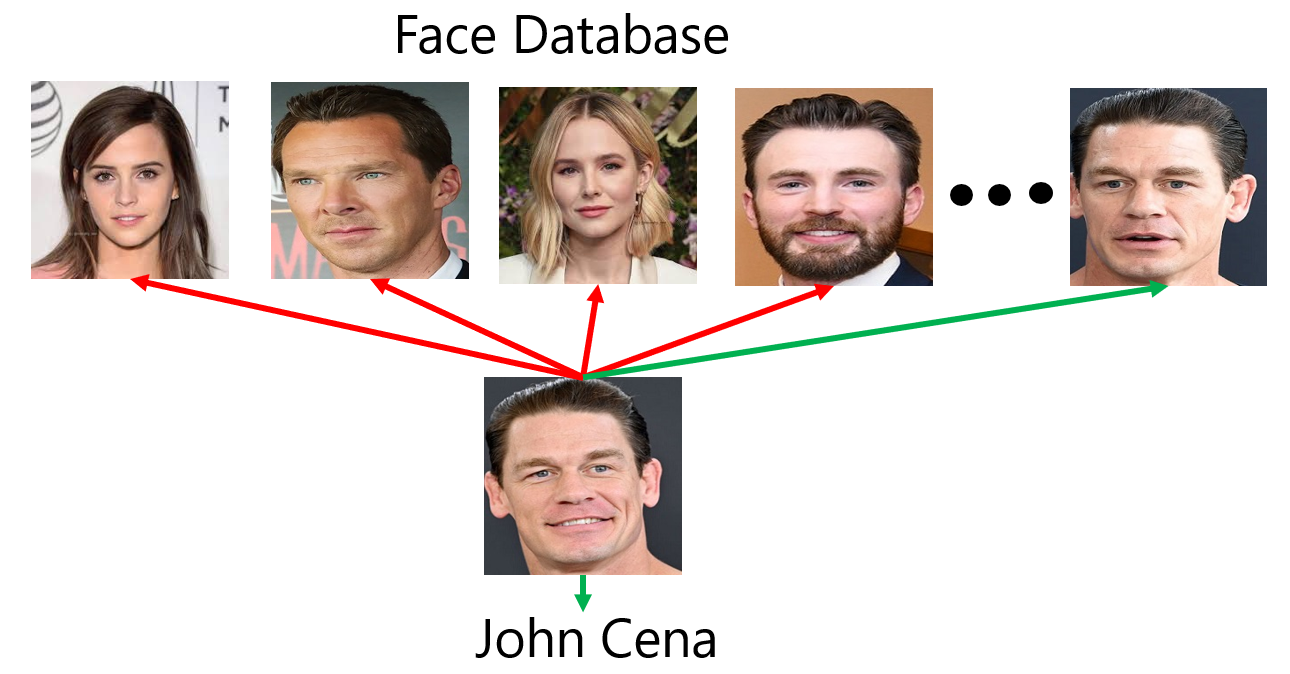

## **Naive Face Verification**

First let us consider a naive approach for Face Verification. You are given two images and you have to tell if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images are less than a chosen threshold, we can declare a match! 

Of course, this algorithm performs really poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, even minor changes in head position, and so on. 

You will see that rather than using the raw image, you can learn an encoding $f(img)$ using the deep learning model so that element-wise comparisons of this encoding gives a more accurate judgements as to whether two pictures are of the same person. We will try to implement such an algorithm in this project.
    
**In this project, you will:**
- Use a pre-trained VGG16 model to map face images into 128-dimensional encodings
- Design a siamese network architecture to learn the correct feature encodings of each image.
- Optimize the triplet loss function for learning the parameters
- Use the feature encodings to perform face recognition

Training a Convolution Neural Network(CNN) from scratch takes a lot of data, time and also compute power. So we instead use **transfer learning** for this project where a model already trained on similar large dataset is fine-tuned as per our requirement. The Visual Geometry Group (VGG) at Oxford has built three models — VGG-16, ResNet-50, and SeNet-50 trained for face recognition as well as for face classification. We will  use the VGG-16 model as it is a smaller model and the real-time prediction can work on a local system with medium configuration. More information can be found from this paper here (https://www.robots.ox.ac.uk/~vgg/publications/2015/Parkhi15/parkhi15.pdf). 

There are **three activities** for you to complete. You can do these activities in the recitations of **Nov 23 and Nov 30**.

Before you proceed, please make sure you are using GPUs for this project. Click Runtime at the top of the page and select (change runtime type) option. Finally select GPU from dropdown options and Save.

Before executing the following python code, you have to upload the `Face_Recognition` folder to your Google drive. Download the project from github repo and upload it into the `My Drive/Colab Notebooks` of your google drive.Then mount the google drive and set the working directory to `My Drive/Colab Notebooks/Face_Recognition`.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
root_dir = "/content/gdrive/MyDrive/"
project_folder = "Colab Notebooks/Face_Recognition/"
os.chdir(root_dir+project_folder)

# **1. Dataset & Preprocessing**

First let us downlaod the dataset compressed as .7z file. Note that only run the following command if you are running it on Google Colab. Alternatively you can use the this link (
https://drive.google.com/file/d/1F1-rDlt8YIrRM1PpcnCU_vpyEgMHJ0NJ/view?usp=sharing) to download the dataset in your system (`project_folder`).

In [ ]:
!gdown --id 1F1-rDlt8YIrRM1PpcnCU_vpyEgMHJ0NJ

Let us extract the downloaded and compressed dataset by running the following command. 

**Note that only run the following command if you are running it on Google Colab.** 

In [ ]:
! 7z x dataset.7z

Now let us download the pretrained VGG16 weight which we will use later as a part of transfer learning. 

**Note that only run the following command if you are running it on Google Colab.**

Alternatively you can use the this link (https://drive.google.com/file/d/1hVYxpi4RJWOQiPGSYqTAVb34DFvrg9bj/view?usp=sharing) to download the pretrained weights in your system.

In [ ]:
!gdown --id 1hVYxpi4RJWOQiPGSYqTAVb34DFvrg9bj

Let us import some important libraries by running the cell below required for our model and data manipulation. 

In [ ]:
import os
import cv2
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from datetime import datetime
from sklearn.utils import shuffle

%load_ext tensorboard


Run the following cell to check if you are using a GPU. You will get a message `Found GPU at: /device:GPU:0` if you have selected GPU for the whole processing.

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Running the following cell will set the number of epochs and set the checkpoint path for the model.

In [ ]:
epochs = 50

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00006)
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

# base_dir = "."
base_dir = os.getcwd()+"/"

stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join(base_dir, 'logs/func/%s' % stamp)
writer = tf.summary.create_file_writer(logdir)

scalar_logdir = os.path.join(base_dir, 'logs/scalars/%s' % stamp)
file_writer = tf.summary.create_file_writer(scalar_logdir + "/metrics")

checkpoint_path = os.path.join(base_dir, 'logs/model/siamese')



Let us get introduced to the dataset before using it to train the model. Oxford group released the VGGFace2 dataset consisting of 8631 celebrity images for training, and 500 of them in the testing, each of them are distinct. We will use a smaller subset of that dataset stored as a compressed file (dataset.7z) for this assignment. The dataset contains an image folder with directories (n000001, n000009, etc.) where each folder is allotted to a celebrity for all its images. Also, there is a file list.txt in the dataset directory, which contains the data as follows directory-name/image-name for each image. This list.txt is used for memory optimization during training. 

The model will need to read the input images as numpy arrays. Therefore the `preprocess_input(..)` function organizes the array in the correct order before sending the data to the model as inputs. Run the following cell to implement the `preprocess_input()` funcion.`preprocess_inpu()` will also normalize the pixel values by subtracting channel-wise means, e.g., 93.5940, 104.7624 etc..

Keras is a model-level library, providing high-level building blocks for developing deep learning models. It does not handle itself low-level operations such as tensor products, convolutions and so on. Instead, it relies on a specialized, well-optimized tensor manipulation library to do so, serving as the "backend engine" of Keras. We use tensorflow as the backend engine.

In [ ]:
K = tf.keras.backend

def preprocess_input(x, data_format=None, version=1):
    x_temp = np.copy(x)
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}

    if version == 1:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 93.5940
            x_temp[:, 1, :, :] -= 104.7624
            x_temp[:, 2, :, :] -= 129.1863
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 93.5940
            x_temp[..., 1] -= 104.7624
            x_temp[..., 2] -= 129.1863

    elif version == 2:
        if data_format == 'channels_first':
            x_temp = x_temp[:, ::-1, ...]
            x_temp[:, 0, :, :] -= 91.4953
            x_temp[:, 1, :, :] -= 103.8827
            x_temp[:, 2, :, :] -= 131.0912
        else:
            x_temp = x_temp[..., ::-1]
            x_temp[..., 0] -= 91.4953
            x_temp[..., 1] -= 103.8827
            x_temp[..., 2] -= 131.0912
    else:
        raise NotImplementedError

    return x_temp

Now we are going to create a data generator class that is reposible for feeding data systematically as batches to the model while training. The function will rendomly generate image triplets (A, P, N) for the training.

$__getitem__$ is the most important function. However, to understand the same, let us check the constructor and other methods as well.

$__init__$: The constructor takes the path to the dataset directory defined in the previous subsection. The constructor uses the list.txt to make a dictionary. This dictionary has the directory name as its key and a list of images in that directory as its value. It is here, and in the shuffling step, that the list.txt becomes an easy way for us to have a dataset overview, thus avoiding to load images for shuffling.

$__getitem__$: We get the names of the people from the above dictionary keys. For 1st batch, the first 32 (batch size) people images are used as anchors, and a different image, of the same person, is used as positives. A negative image, from any other directory, is selected for training. For all of the triplets, the anchors, the positive, and the negative images are chosen randomly. The next 32 people become the anchor for the next batch.
curate_dataset: Creates the dictionary explained in the $__init__$

**on_epoch_end:** On each epoch end, the order of people is shuffled, so that in the next epoch, the first 32 images are different than the one seen in the previous epoch.

**get_image:** The get image function uses the preprocess_input after resizing the image to (224 x 224) size. 

__len__: This will return the number of batches that will define one epoch.


In [ ]:

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataset_path, batch_size=16, shuffle=True):
        self.dataset = self.curate_dataset(dataset_path)
        self.dataset_path = dataset_path
        self.shuffle = shuffle
        self.batch_size =batch_size
        self.no_of_people = len(list(self.dataset.keys()))
        self.on_epoch_end()
        
    def __getitem__(self, index):
        people = list(self.dataset.keys())[index * self.batch_size: (index + 1) * self.batch_size]
        P = []
        A = []
        N = []
        
        for person in people:
            anchor_index = random.randint(0, len(self.dataset[person])-1)
            a = self.get_image(person, anchor_index)
            
            positive_index = random.randint(0, len(self.dataset[person])-1)
            while positive_index == anchor_index:
                positive_index = random.randint(0, len(self.dataset[person])-1)
            p = self.get_image(person, positive_index)
            
            negative_person_index = random.randint(0, self.no_of_people - 1)
            negative_person = list(self.dataset.keys())[negative_person_index]
            while negative_person == person:
                negative_person_index = random.randint(0, self.no_of_people - 1)
                negative_person = list(self.dataset.keys())[negative_person_index]
            
            negative_index = random.randint(0, len(self.dataset[negative_person])-1)
            n = self.get_image(negative_person, negative_index)
            P.append(p)
            A.append(a)
            N.append(n)
        A = np.asarray(A)
        N = np.asarray(N)
        P = np.asarray(P)
        return [A, P, N]
        
    def __len__(self):
        return self.no_of_people // self.batch_size
        
    def curate_dataset(self, dataset_path):
        with open(os.path.join(dataset_path, 'list.txt'), 'r') as f:
            dataset = {}
            image_list = f.read().split()
            for image in image_list:
                folder_name, file_name = image.split('/')
                if folder_name in dataset.keys():
                    dataset[folder_name].append(file_name)
                else:
                    dataset[folder_name] = [file_name]
        return dataset
    
    def on_epoch_end(self):
        if self.shuffle:
            keys = list(self.dataset.keys())
            random.shuffle(keys)
            dataset_ =  {}
            for key in keys:
                dataset_[key] = self.dataset[key]
            self.dataset = dataset_
            
    def get_image(self, person, index):
        img = cv2.imread(os.path.join(self.dataset_path, os.path.join('images/' + person, self.dataset[person][index])))     
        img = cv2.resize(img, (224, 224))        
        img = np.asarray(img, dtype=np.float64)
        img = preprocess_input(img)
        return img

# **2.Encoding the Face Images**

In this part we build our main VGG16 face recognition model and understand the concept of transfer learning. You may replace VGG16 with AlexNet or other classical netwoks and redo this project later. Specifically, We will encode the face images into 128-dinensional vectors. The key things you need to know are:

- The VGG16 network that we are going to build uses 224x224 dimensional RGB images as its input. Specifically, inputs a face image (or batch of $m$ face images) as a tensor of shape $(m, n_H, n_W, n_C) = (m, 224, 224, 3)$ 
- It outputs a matrix of shape $(m, 128)$ that encodes each input face image into a 128-dimensional vector

The VGG-16 model was trained on a very large VGGface dataset, where they had trained the classification model on 2622 different faces. In the following cell, we need to load the pretrained weights of that model. The second to last layer has 4096 Dense Units to which we append a 128 unit Dense layer, without the bias term, and remove the classification/softmax layer containing 2622 units. All the layers before the 128 Dense layer are frozen (trainable = False) and only the newly added dense layer needs to be trained. This dense layer will be responsible to outputs a matrix of shape  (𝑚,128)  that encodes each input face image into a 128-dimensional vector. Please refer to the  VGG16 architecture given below to complete ACtivity 1.

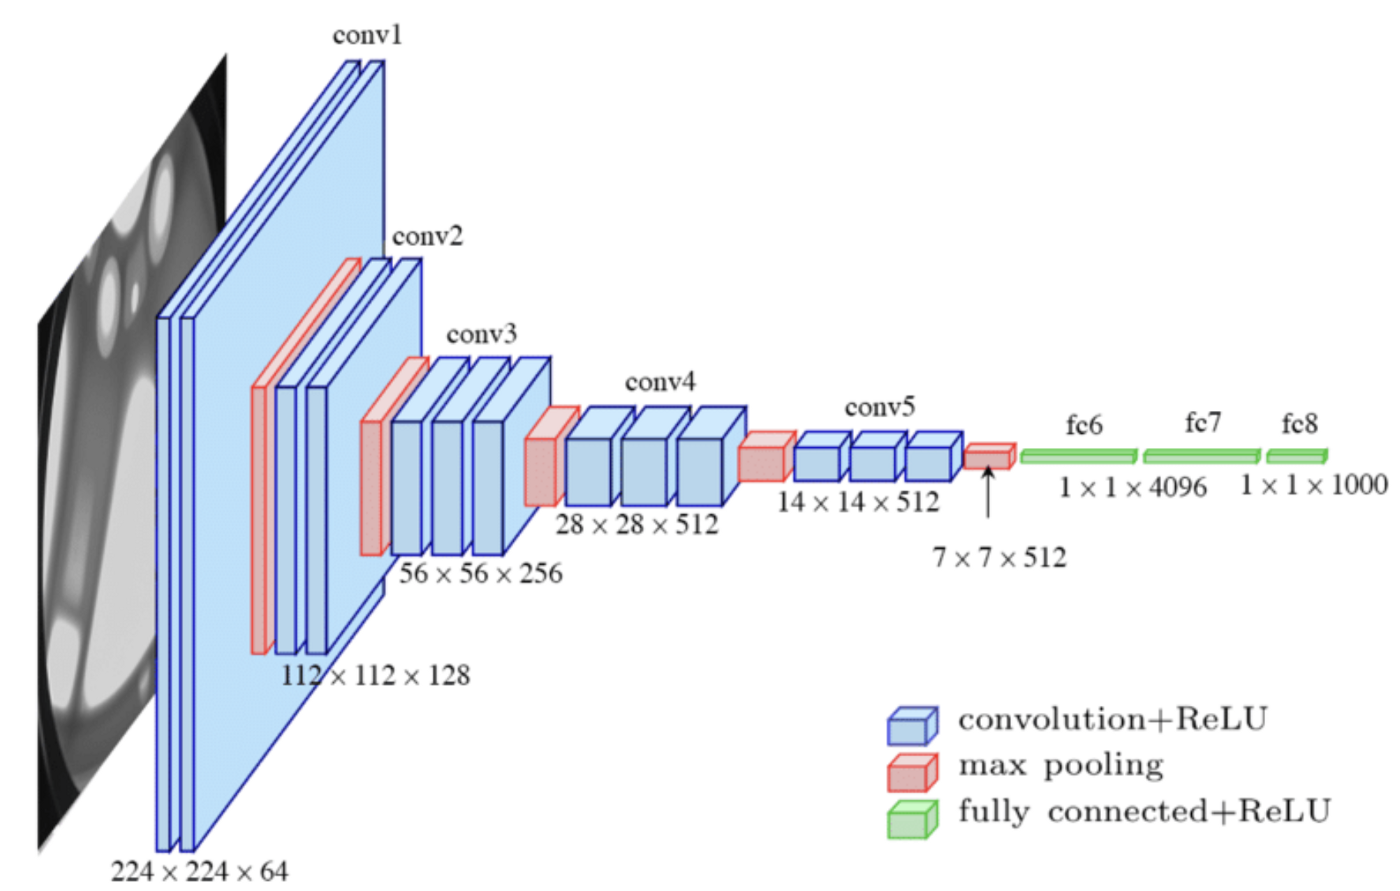

In the following cell, for building the main model you have to use `MyModel.pop()` function to remove the last layer of the VGG16 and then use `MyModel.add(tf.keras.layers.Dense(128, use_bias=False))` to append a 128 unit Dense layer, without the bias term.

In [ ]:
#Activity 1
MyModel = tf.keras.models.Sequential()

#First few convolution layers
MyModel.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME", input_shape=(224,224, 3)))
MyModel.add(tf.keras.layers.Convolution2D(64, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))
 
MyModel.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.Convolution2D(128, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

#Add 5,6,7 conv layers of VGG16
MyModel.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.Convolution2D(256, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

#Add 8,9, and 10 layers of VGG16
MyModel.add(tf.keras.layers.Convolution2D(_____, (___, ____), activation=_____, padding=_____))
MyModel.add(tf.keras.layers.Convolution2D(_____, (___, ____), activation=____, padding=_____))
MyModel.add(tf.keras.layers.Convolution2D(____, (___, ____), activation=_____, padding="_____"))
MyModel.add(tf.keras.layers.MaxPooling2D((____,____), strides=(___,_____)))


#Add 11,12, and 13 layers of VGG16
MyModel.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.Convolution2D(512, (3, 3), activation='relu', padding="SAME"))
MyModel.add(tf.keras.layers.MaxPooling2D((2,2), strides=(2,2)))

MyModel.add(tf.keras.layers.Flatten())

#Fully connected layers (14, 15 and 16)
MyModel.add(tf.keras.layers.Dense(4096, activation='relu'))
MyModel.add(tf.keras.layers.Dropout(0.5))
MyModel.add(tf.keras.layers.Dense(4096, activation='relu'))
MyModel.add(tf.keras.layers.Dropout(0.5))
MyModel.add(tf.keras.layers.Dense(2622, activation='softmax'))

#We will use the pre-trained weights for the VGG16. Let us load the pre-trained weights.
MyModel.load_weights(os.path.join(base_dir, 'PreTrained_Weight_vgg16.h5'))
#Remove the last layer of VGG16
____________________

#Append a 128 unit dense layer without bias term (refer to the description above)
_______________________

#Let us make the last dense layer trainable since we are using pretrained weights for previous layers.
for layer in MyModel.layers[:-1]:
    layer.trainable = True 

Run the two cell below to construct the siamese architecture that we discussed in the class.

In [ ]:
class SiameseNetwork(tf.keras.Model):
    def __init__(self, MyModel):
        super(SiameseNetwork, self).__init__()
        self.MyModel = MyModel
        
    @tf.function
    def call(self, inputs):
        image_1, image_2, image_3 =  inputs
        with tf.name_scope("Anchor") as scope:
            feature_1 = self.MyModel(image_1)
            feature_1 = tf.math.l2_normalize(feature_1, axis=-1)
        with tf.name_scope("Positive") as scope:
            feature_2 = self.MyModel(image_2)
            feature_2 = tf.math.l2_normalize(feature_2, axis=-1)
        with tf.name_scope("Negative") as scope:
            feature_3 = self.MyModel(image_3)
            feature_3 = tf.math.l2_normalize(feature_3, axis=-1)
        return [feature_1, feature_2, feature_3]
    
    @tf.function
    def get_features(self, inputs):
        return tf.math.l2_normalize(self.MyModel(inputs), axis=-1)

In [ ]:
model = SiameseNetwork(MyModel)



#**3. The Triplet Loss**

In this part of the assignment we will learn about the loss funtion used for learning while training the model. The Triplet loss function is a well known loss function for face recognision model first introduced in this paper (https://arxiv.org/pdf/1503.03832.pdf).

For an image $x$, we denote its encoding $f(x)$, where $f$ is the function computed by the neural network.

<!--
We will also add a normalization step at the end of our model so that $\mid \mid f(x) \mid \mid_2 = 1$ (means the vector of encoding should be of norm 1).
!-->

Training will use triplets of images $(A, P, N)$:  

- A is an "Anchor" image--a picture of a person. 
- P is a "Positive" image--a picture of the same person as the Anchor image.
- N is a "Negative" image--a picture of a different person than the Anchor image.

These triplets are picked from our training dataset. We will write $(A^{(i)}, P^{(i)}, N^{(i)})$ to denote the $i$-th training example, see the below figure. 



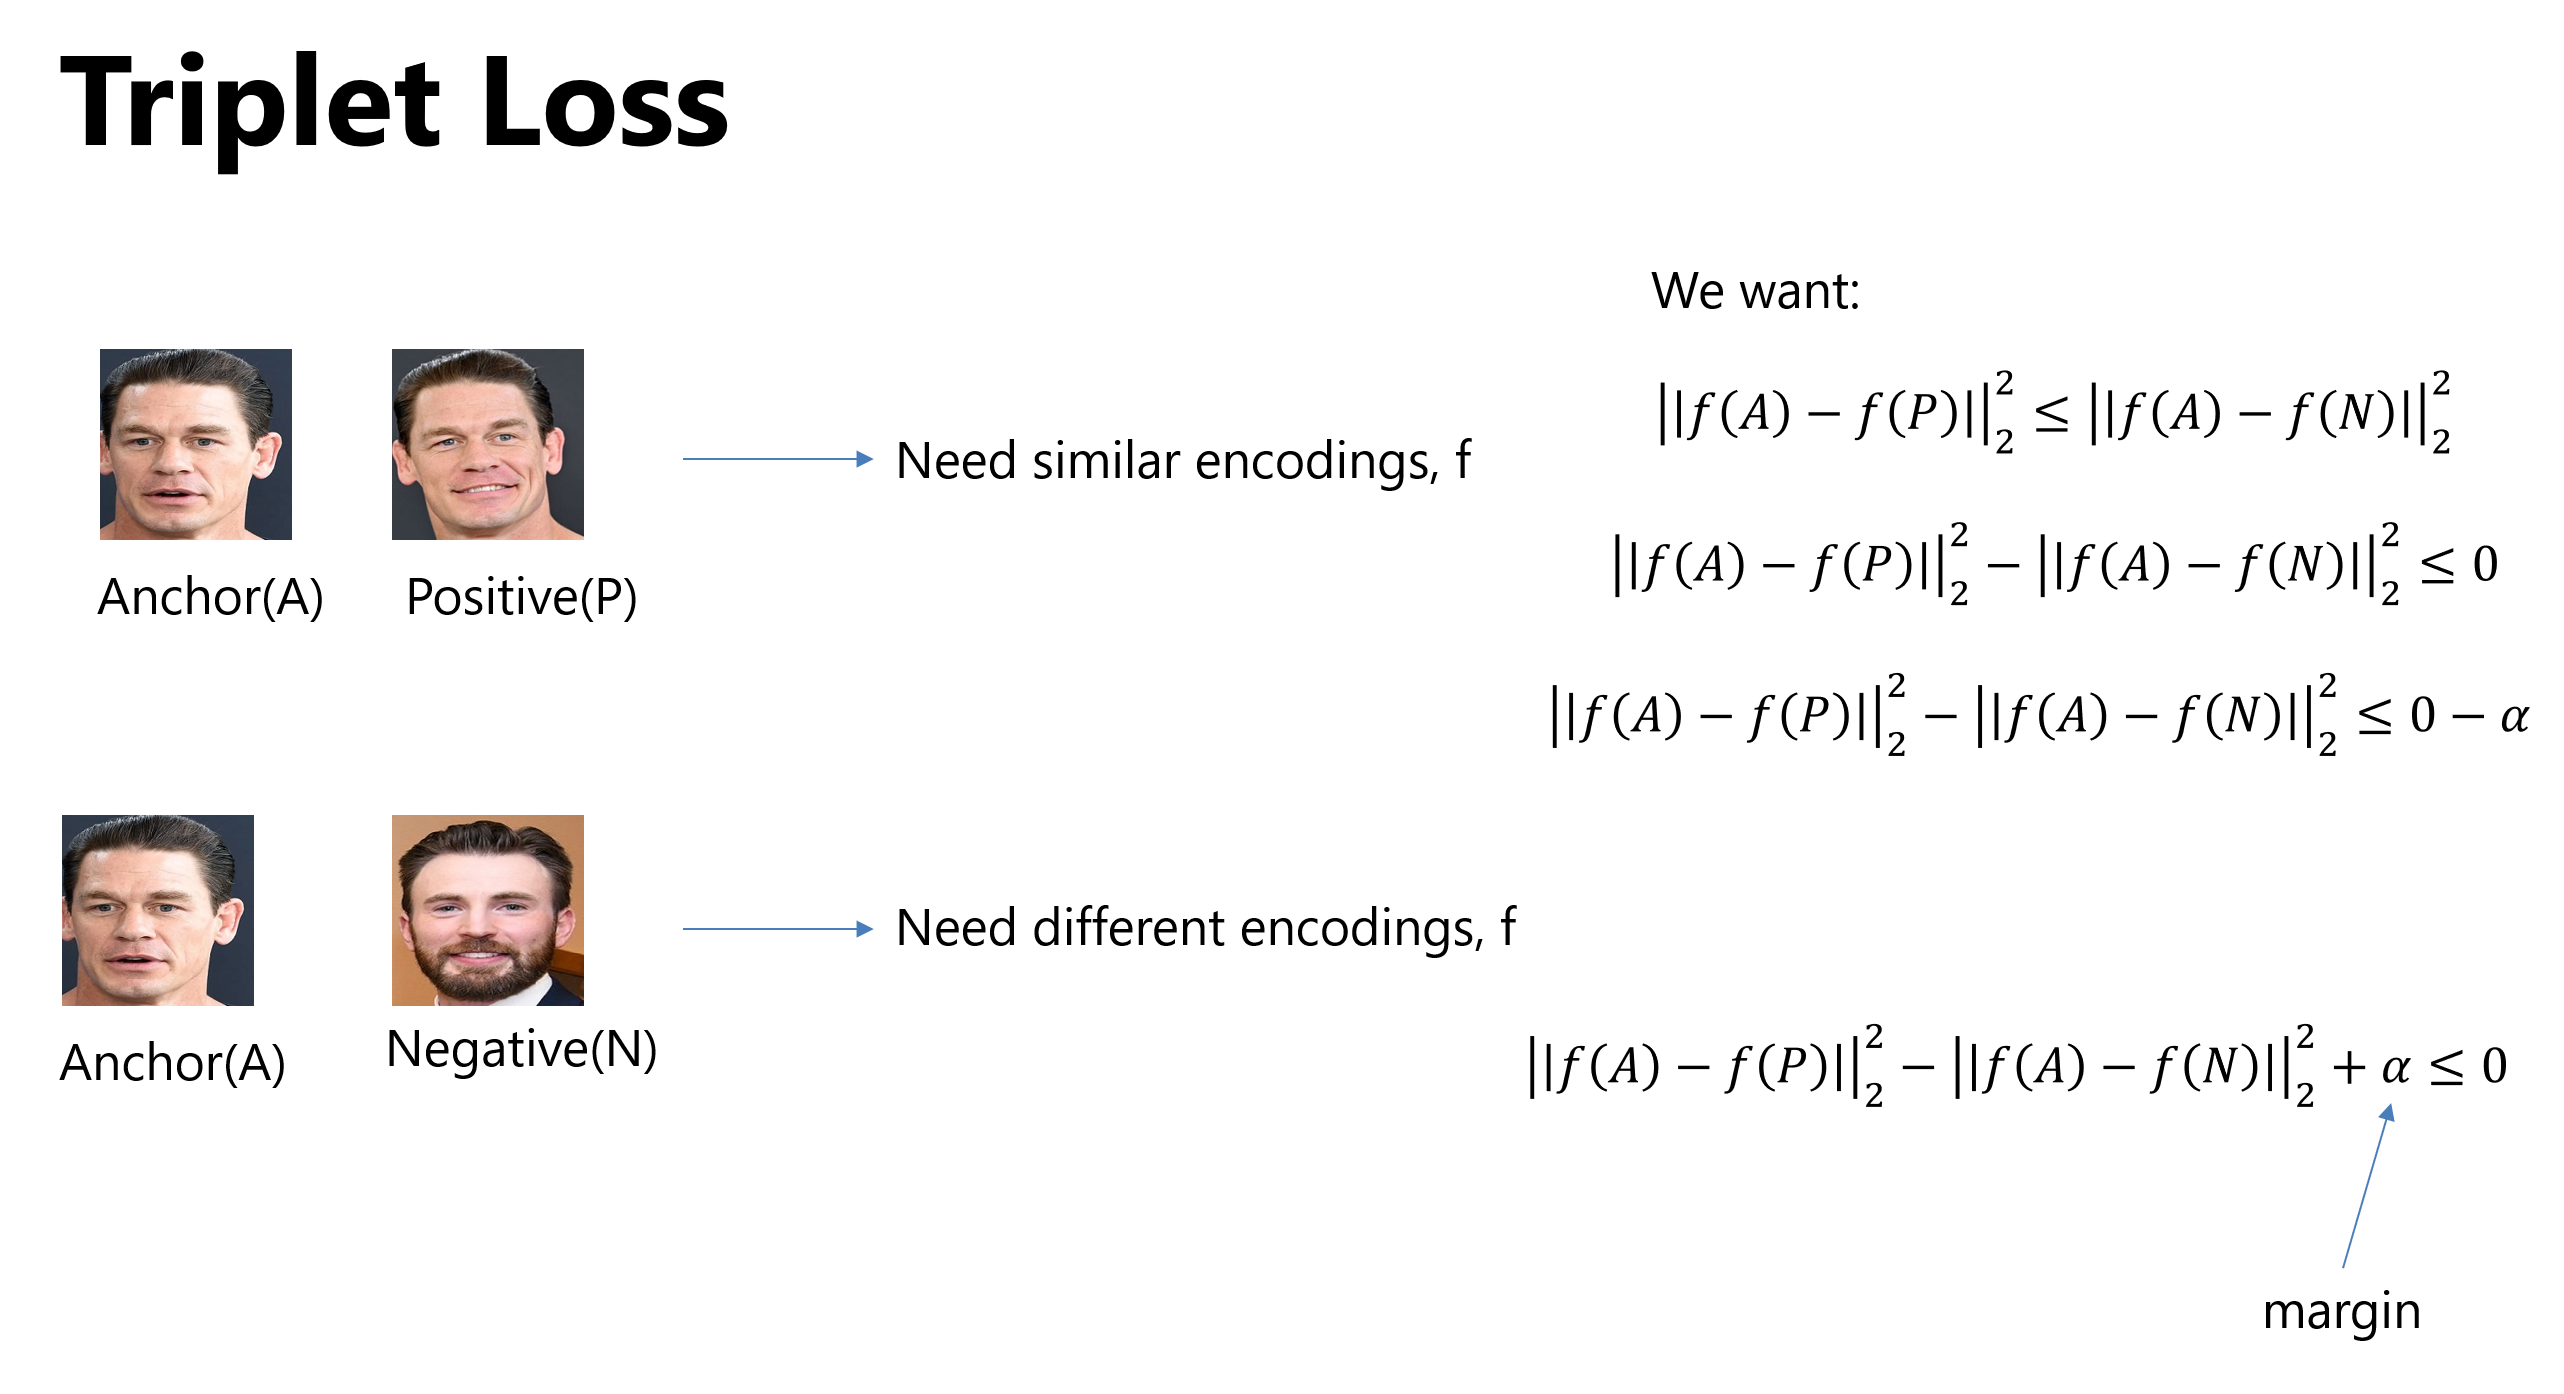

You'd like to make sure that an image $A^{(i)}$ of an individual is closer to the Positive $P^{(i)}$ than to the Negative image $N^{(i)}$) by at least a margin $\alpha$:

$$\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 + \alpha < \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$$

You would thus like to minimize the following "triplet cost":

$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \underbrace{\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2}_\text{(1)} - \underbrace{\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2}_\text{(2)} + \alpha \large ] \small_+ \tag{3}$$

Here, we are using the notation "$[z]_+$" to denote $max(z,0)$.  

Notes:
- The term (1) is the squared distance between the anchor "A" and the positive "P" for a given triplet; you want this to be small. 
- The term (2) is the squared distance between the anchor "A" and the negative "N" for a given triplet, you want this to be relatively large, so it thus makes sense to have a minus sign preceding it. 
- $\alpha$ is called the margin. It is a hyperparameter that you should pick manually. We will use $\alpha = 0.2$. 

Most implementations also normalize the encoding vectors  to have norm equal one (i.e., $\mid \mid f(img)\mid \mid_2$=1); you won't have to worry about that here.

**Your task:** Implement the triplet loss as defined by formula (3). Here are the 4 steps:
1. Compute the distance between the encodings of "anchor" and "positive": $\mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2$
2. Compute the distance between the encodings of "anchor" and "negative": $\mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2$
3. Compute the formula per training example: $ \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2 + \alpha$
3. Compute the full formula by taking the max with zero and summing over the training examples:
$$\mathcal{J} = \sum^{N}_{i=1} \large[ \small \mid \mid f(A^{(i)}) - f(P^{(i)}) \mid \mid_2^2 - \mid \mid f(A^{(i)}) - f(N^{(i)}) \mid \mid_2^2+ \alpha \large ] \small_+ \tag{3}$$

Useful hints:

* For the distance between the encodings of "anchor" and "positive" you can use `K.sum()` and `K.square()` functions with the appropriate arguments. here `K` is the backend already imported from keras, see details on backend and different functions at https://faroit.com/keras-docs/1.2.0/backend/

* For calculating distance between the encodings of "anchor" and "negative" you can use a simlar expression as above.

* For computing the full formula by taking the max with zero and summing over the training examples you can use  `basic_loss = pos_dist-neg_dist+alpha`  and then `loss = K.mean(K.maximum(basic_loss,0.0))`

In [ ]:
# Activity 2

def loss_function(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
   
    
    # Distance between the anchor and the positive. Use the functions from the backend K. K.sum(K.square(____), axis=1)
    pos_dist = K.sum(K.square(__________),axis=1)
    # Distance between the anchor and the negative
    neg_dist = K.sum(K.square(_________),axis=1)
    # compute loss, refer to the Equation 3 and Task 3 described above. Hint: positive distance + negative distance + alpha?
    basic_loss = ________________
    #Refer to Equation 3 and Task 4. You may want to use K.mean(K.maximum(__,__))
    loss = K.mean(K.maximum(_____,_______))    
    
    return loss

Run the following cells to define the training parameters.

In [ ]:
def train(X):
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = loss_function(y_pred)
    grad = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grad, model.trainable_variables))
    return loss

In [ ]:
tf.summary.trace_on(graph=True, profiler=False)
output = model([tf.zeros((32,224,224,3)), tf.zeros((32,224,224,3)), tf.zeros((32,224,224,3))])
with writer.as_default():
    tf.summary.trace_export(name="my_func_trace", step=0, profiler_outdir=logdir)
    
tf.summary.trace_off()

Run the following cell to construct data_generator class 

In [ ]:
data_generator = DataGenerator(dataset_path='./dataset/')

In [ ]:
a, p, n = data_generator[0]

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)

The following cell will start the model training. It might take around 20-25 minutes to train based on the GPU selected by google colab.

In [ ]:
losses = []
accuracy = []

no_of_batches = data_generator.__len__()
for i in range(1, epochs+1, 1):
    loss = 0
    with tqdm(total=no_of_batches) as pbar:
        
        description = "Epoch " + str(i) + "/" + str(epochs)
        pbar.set_description_str(description)
        
        for j in range(no_of_batches):
            data = data_generator[j]
            temp = train(data)
            loss += temp
            
            pbar.update()
            print_statement = "Loss :" + str(temp.numpy())
            pbar.set_postfix_str(print_statement)
        
        loss /= no_of_batches
        losses.append(loss.numpy())
        with file_writer.as_default():
            tf.summary.scalar('Loss', data=loss.numpy(), step=i)
            
        print_statement = "Loss :" + str(loss.numpy())
        
        pbar.set_postfix_str(print_statement)

checkpoint.save(checkpoint_path)
print("Checkpoint Saved")

**Expected Output**:

<table>
    <tr>
        <td>
            **loss**
        </td>
        <td>
            0.03...
        </td>
    </tr>

</table>

# **4. Testing the Model Performance**

A folder named `images` is included in the root directory. The folder contains images for testing.

Running the next three cell will prepare the model we just trained for prediction using the checkpoint path. 

In [ ]:
_ = model([tf.zeros((32,224,224,3)), tf.zeros((32,224,224,3)), tf.zeros((32,224,224,3))])
_ = model.get_features(tf.zeros((32,224,224,3)))

In [ ]:
#base_dir = "."
checkpoint_path = "./logs/model/checkpoint"

In [ ]:
checkpoint = tf.train.Checkpoint(model=model)

Run the following cell to import library for input/test images.

In [ ]:
from PIL import Image
from numpy import asarray


First we will build a database containing one encoding vector for each person we want to recognise by our system. To generate the encoding we use `img_to_encoding(image_path, model)` function which basically runs the forward propagation of the model on the specified image. 

In [ ]:
def img_to_encoding(image_path, model):
    img1 = cv2.imread(image_path, 1)    
    img = img1[...,::-1]
    img = np.around(np.transpose(img, (2,0,1))/255.0, decimals=12)
    img = np.moveaxis(img, 0, -1)
    x_train = np.array([img])    
    embedding = model.get_features(x_train)
    return embedding

Run the following code to build the database (represented as a python dictionary). This database maps each person's name to a 128-dimensional encoding of their faces.

In [ ]:
database = {}
database["Bryan"] = img_to_encoding("images/Bryan.jpg", model)
database["Benedict"] = img_to_encoding("images/Benedict.jpg", model)
database["Chris"] = img_to_encoding("images/Chris.jpg", model)
database["Depp"] = img_to_encoding("images/Depp.jpg", model)
database["Gus"] = img_to_encoding("images/Gus.jpg", model)
database["John"] = img_to_encoding("images/John.jpg", model)


#**5.Face Recognition App**

Next, you will implement a face recognition system that takes as input an image, and figures out if it is one of the authorized persons recorded in the database. 

Your task is to implement `who_are_you()`. You will have to go through the following steps:
1. Compute the target encoding of the image from image_path
2. Find the encoding from the database that has smallest distance with the target encoding. 
    - Initialize the `min_dist` variable to a large enough number (100). It will help you keep track of what is the closest encoding to the input's encoding.
    - Loop over the database dictionary's names and encodings. To loop use `for (name, db_enc) in database.items()`.
        - Compute L2 distance between the target "encoding" and the current "encoding" from the database.
        - If this distance is less than the min_dist, then set min_dist to dist, and identity to name.

In [ ]:
# Activity 3

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow


def who_are_you(image_path, database, model):
    """
    Implements face recognition by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
      
    
    ## Step 1: Compute the target "encoding" for the image. Use img_to_encoding() see example above. 
    encoding = _____________________
    
    ## Step 2: Find the closest encoding ##

    # Initialize "min_dist" to a large value, say 100 
    min_dist = __________
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "feature" from the database (database[name]). np.linalg.norm may be useful
        dist = _________________

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. 
        if _______:
            min_dist = _________
            identity = _________

    
    if min_dist > 0.6:
        print("Not in the database. Hence the entry is not allowed!")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))      
               
    return min_dist, identity

Suppose John is at the front-door and the camera takes a picture of him ("images/john2.jpg"). Let's see whether your `who_are_you()` algorithm identifies John. 

In [ ]:
who_are_you("images/John2.jpg", database, model)
img= plt.imread("images/John2.jpg")
plt.imshow(img)

**Expected Output**:

<table>
    <tr>
        <td>
            **it's John, the distance is 0.24..**
        </td>
        <td>
           (0.24..., 'John')
        </td>
    </tr>

</table>

Suppose Taylor is at the front-door and the camera takes a picture of him ("images/john2.jpg"). He is not in the stored database. Let us see what your `who_are_you()` algorithm will return.

In [ ]:
who_are_you("images/Depp.jpg", database, model)
img= plt.imread("images/Depp.jpg")
plt.imshow(img)

In [ ]:
who_are_you("images/taylor.jpg", database, model)

**What you should remember**:
- Face verification solves an easier 1:1 matching problem; face recognition addresses a harder 1:K matching problem. 
- The triplet loss is an effective loss function for training a neural network to learn an encoding of a face image.
- The same encoding can be used for verification and recognition. Measuring distances between two images' encodings allows you to determine whether they are pictures of the same person. 

**Congrats** on finishing this project! 


#**6. Evaluation Details**
The project will be explained in the recitation on Nov. 23. You will get a total of 14 days to complete the activities. You have to read the instructions, refer to the slides and do all the exercises, refer to the materials as and when necessary (especially for syntaxes). The marker will evaluate your work during the recitation on Dec. 7. During the evaluation, you will be asked to show the graded activities and you may expect a couple of related questions.

**NOTE** In case you are unable to attend the recitation, you have to inform the instructor before the recitation and absence due to sickness orr other genuine grounds will be considered.

#**7. References**

1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)
2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf) 

3. Q. Cao, L. Shen, W. Xie, O. M. Parkhi, A. Zisserman
[VGGFace2: A dataset for recognising faces across pose and age ](https://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) 
International Conference on Automatic Face and Gesture Recognition, 2018

